In [1]:
"""In this notebook we demonstrate using the kinetic dispersion solver to 
compute the solution to the anomalous Doppler instability. """
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from KineticDispersion import Solver, Species
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#%matplotlib notebook

In [2]:
"""Define physical constants"""
e0 = 8.85E-12
mu0 = 1.26E-6
e = 1.6E-19
kb = 1.38E-23
me = 9.11E-31
ev = 11500

In [3]:
labelsize=9
fontsize=12

def singleFigure():
    """Sets up a single panel figure. """
    fig, ax = plt.subplots(1, 1, figsize=(3.8, 3.42))
    plt.subplots_adjust(left=0.13, right=0.87, top=0.98, bottom=0.14)
    ax.tick_params('x', labelsize=labelsize)
    ax.tick_params('y', labelsize=labelsize)
    lbaxes = fig.add_axes([0.11, 0.14, 0.78, 0.84], frameon=False)
    lbaxes.set_xticks([])
    lbaxes.set_yticks([])
    lbaxes.yaxis.tick_right()
    lbaxes.tick_params('y', labelsize=labelsize)
    lbaxes.yaxis.set_label_position("right")
    return fig, ax, lbaxes

def wideFigure():
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 2.2914))
    plt.subplots_adjust(left=0.08, right=0.92, top=0.97, bottom=0.23)
    fig.subplots_adjust(hspace=0.075, wspace=0.075)
    ax.tick_params('x', labelsize=labelsize)
    ax.tick_params('y', labelsize=labelsize)
    lbaxes = fig.add_axes([0.06, 0.23, 0.88, 0.74], frameon=False)
    lbaxes.set_xticks([])
    lbaxes.set_yticks([])
    lbaxes.yaxis.tick_right()
    lbaxes.tick_params('y', labelsize=labelsize)
    lbaxes.yaxis.set_label_position("right")
    return fig, ax, lbaxes

In [4]:
"""Define constants for the two stream instability"""
Te = 100*ev #electron temperature
vth = (kb*Te/me)**0.5 #thermal velocity
ne = 2.5E19 #number density per metre cubed
B = 2.0
vm = 18.5*vth #maximum parallel velocity
xi = 0.04
wpe = (ne*e**2/(e0*me))**0.5 #Plasma frequency
wce = e*B/me #Electron cyclotron frequency

In [16]:
"""Set constants for plotting"""
wunit = wpe #The unit which we normalize frequency to. 
kunit = wunit/vth #The unit we normalize wavenumber to. 
fvmin = -5 #Minimum log probability to plot
viewbounds = (-0.3, 0.3, 0.0, 2.0)#The range of values we plot within. 

In [17]:
"""Compute two streaming maxwellians. Distributions are truncated at 5vth"""
npara = 1000
nperp = 1000
vpara = np.linspace(-5.0, 22.0, npara)*vth
vperp = np.linspace(0.0, 5.0, nperp)*vth

vbm = vth*np.log(vm**2*(1-xi)**2/(vth**2*2*np.pi*xi**2))**0.5
Fvpara = (vpara<vbm)*(1-xi)*np.exp(-0.5*vpara**2/(vth**2))/ \
(2*np.pi*vth**2)**0.5 + ((vpara>vbm) & (vpara<vm))*xi*1.0/vm + \
(vpara>vm)*xi*np.exp(-0.5*(vpara - vm)**2/vth**2)/vm
Fvperp = np.exp((-0.5*vperp**2/(vth**2)))
Fv = np.outer(Fvpara, Fvperp)

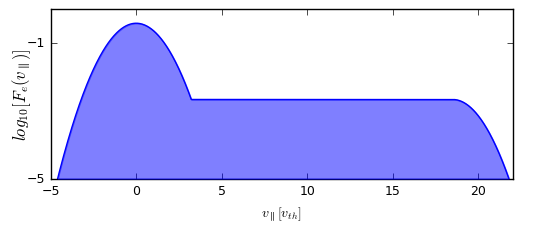

In [18]:
fig, ax, lbaxes = wideFigure()
ax.fill_between(vpara/vth, np.log10(Fvpara*vth), fvmin, 
                where=np.log10(Fvpara*vth)>fvmin, 
                color='blue', alpha=0.5, zorder=100)
ax.plot(vpara/vth, np.log10(Fvpara*vth))
ax.set_xlim(-5, 22)
ax.set_ylim(-5, 0)
ax.set_yticks(ax.get_yticks()[::4])
lbaxes.yaxis.set_label_position("left")
lbaxes.set_ylabel('$log_{10}[F_e(v_{\parallel})]$', fontsize=fontsize)
ax.set_xlabel('$v_{\parallel}[v_{th}]$')

In [19]:
"""Create a species object for each beam. """
s1 = Species(-1*e, me, ne, vpara, vperp, Fv, np.arange(-1, 2))

"""Create a dispersion solver using a list of species. """
solver = Solver(B, [s1])

In [40]:
"""Solve at 45 degrees. """
theta = 45*np.pi/180
"""ww defines the frequencies which we plot in the background"""
ww = np.linspace(viewbounds[2]*wpe, viewbounds[3]*wpe, 100)+ 0.0001j*wpe
kk = np.linspace(viewbounds[0]*kunit, viewbounds[1]*kunit, 400)
"""We use a 2D array of guesses, defined by a real and imaginary components wwr, wwi. """
wwr = np.linspace(0.00001*wpe, 2*wpe, 100)
wwi = np.linspace(0.000001j*wpe, 0.005j*wpe, 10)
ww2 = np.outer(wwr, np.ones(len(wwi))) + np.outer(np.ones(len(wwr)), wwi)
"""k has a parallel and perpendicular component. """
kkpara = kk*np.cos(theta)
kkperp = kk*np.sin(theta)
"""Set up the values of k we will solve for as a list. """
klist = np.array((kkpara, kkperp)).T

In [41]:
"""The problem is embarassingly parallel so we construct a process pool. """
"""Here we have used a desktop supporting 8 concurrent threads. """

"""Define functions to be mapped to the process pool. """
def func(k):
    """Evaluate the insolution at k using ww. """
    marginalized = solver.marginalize(ww, k)
    return marginalized

def func2(k):
    """Find roots using the 2D initial guess array ww2. """
    roots = solver.roots(ww2, k)
    return roots

pool = Pool(8)

try:
    """We construct an array of insolution to plot. """
    insolution = np.array(pool.map_async(func, klist).get(99999))
    roots = pool.map_async(func2, klist).get(99999)
    pool.close()
except:
    pool.terminate() #When an exception is thrown we must terminate cleanly. 
    print 'Pool exception'
finally:
    pool.join()

In [55]:
root_w = []
root_k = []

for rootset, k in zip(roots, klist):
    for root in rootset:
        root_w.append(root[0])
        root_k.append((k[0]**2 + k[1]**2)**0.5*np.sign(k[0]))

        
root_w = np.array(root_w)
root_k = np.array(root_k)

growthmask = np.where(root_w.imag/wunit>1E-4)
dampmask = np.where((root_w.imag/wunit<-1E-4) & (root_w.imag/wunit>-0.025))
stationarymask = np.where(abs(root_w.imag)/wunit<1E-4)

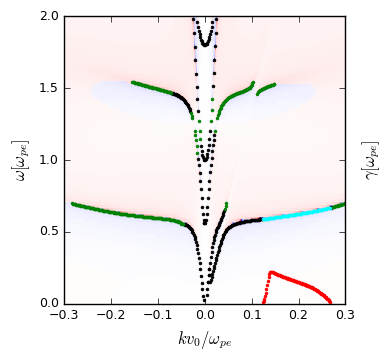

In [56]:
"""Finally we generate the figure. """
fig, ax, lbaxes = singleFigure()
lbaxes.yaxis.set_label_position("right")

im = ax.imshow((np.sign(insolution.real)/np.abs(insolution)**0.5).T,
               aspect='auto', interpolation='nearest', extent=viewbounds, 
               vmin=-2.5E1, vmax=2.5E1, origin='lower', cmap='bwr')
ax.plot(root_k[stationarymask]/kunit, root_w[stationarymask].real/wunit, ls='None', marker='.', color='black', markersize=4)
ax.plot(root_k[dampmask]/kunit, root_w[dampmask].real/wunit, ls='None', marker='.', color='green', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w.imag[growthmask]*100/wunit, ls='None', marker='.', color='red', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w.real[growthmask]/wunit, ls='None', marker='.', color='cyan', markersize=4)
ax.set_ylim(viewbounds[2], viewbounds[3])
ax.set_xlim(viewbounds[0], viewbounds[1])

ax.set_xlabel('$kv_{0}/\omega_{pe}$', fontsize=fontsize)
ax.set_ylabel('$\omega[\omega_{pe}]$', fontsize=fontsize)
lbaxes.set_ylabel('$\gamma[\omega_{pe}]$', fontsize=fontsize)
ax.tick_params('x', labelsize=labelsize)
ax.tick_params('y', labelsize=labelsize)